In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import os
from pathlib import Path

Path('/home/alex/PycharmProjects/', '*').as_posix()

'/home/alex/PycharmProjects/*'

# Vertex Autoencoder

## Visualize

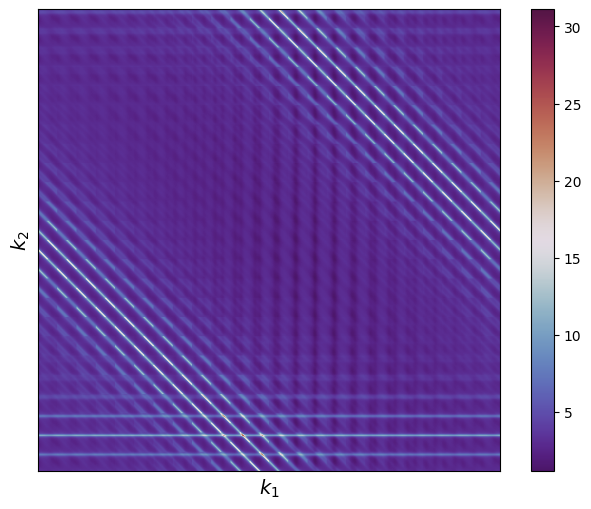

In [2]:
from src.load_data import AutoEncoderVertexV2
from src.visualization import vertex_visualization as vertvis

vertex = AutoEncoderVertexV2.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
vertvis.plot_section(vertex, 255, axis=3, figsize=(8,6))

## Training

In [ ]:
from src.trainer import VertexTrainer, TrainerModes
trainer = VertexTrainer('vertex_v2', 'AUTO_ENCODER_VERTEX_V2', 'confmod_auto_encoder_v2.json')

In [ ]:
trainer.train(train_mode=TrainerModes.LOCAL)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | AutoEncoderVertex | 2.9 M  | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.691    Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 240/240 [00:09<00:00, 24.94it/s, v_num=0, val_loss=0.490]

Epoch 0, global step 240: 'val_loss' reached 0.48956 (best 0.48956), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=0-step=240.ckpt' as top 10


Epoch 1: 100%|██████████| 240/240 [00:02<00:00, 88.51it/s, v_num=0, val_loss=0.489] 

Epoch 1, global step 480: 'val_loss' reached 0.48854 (best 0.48854), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=1-step=480.ckpt' as top 10


Epoch 2: 100%|██████████| 240/240 [00:02<00:00, 93.13it/s, v_num=0, val_loss=0.493] 

Epoch 2, global step 720: 'val_loss' reached 0.49289 (best 0.48854), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=2-step=720.ckpt' as top 10


Epoch 3: 100%|██████████| 240/240 [00:02<00:00, 98.57it/s, v_num=0, val_loss=0.492] 

Epoch 3, global step 960: 'val_loss' reached 0.49214 (best 0.48854), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=3-step=960.ckpt' as top 10


Epoch 4: 100%|██████████| 240/240 [00:02<00:00, 81.90it/s, v_num=0, val_loss=0.486] 

Epoch 4, global step 1200: 'val_loss' reached 0.48563 (best 0.48563), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=4-step=1200.ckpt' as top 10


Epoch 5: 100%|██████████| 240/240 [00:02<00:00, 93.24it/s, v_num=0, val_loss=0.466] 

Epoch 5, global step 1440: 'val_loss' reached 0.46633 (best 0.46633), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=5-step=1440.ckpt' as top 10


Epoch 6: 100%|██████████| 240/240 [00:02<00:00, 95.38it/s, v_num=0, val_loss=0.458] 

Epoch 6, global step 1680: 'val_loss' reached 0.45780 (best 0.45780), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=6-step=1680.ckpt' as top 10


Epoch 7: 100%|██████████| 240/240 [00:02<00:00, 84.58it/s, v_num=0, val_loss=0.408] 

Epoch 7, global step 1920: 'val_loss' reached 0.40806 (best 0.40806), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=7-step=1920.ckpt' as top 10


Epoch 8: 100%|██████████| 240/240 [00:02<00:00, 93.04it/s, v_num=0, val_loss=0.390] 

Epoch 8, global step 2160: 'val_loss' reached 0.38989 (best 0.38989), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=8-step=2160.ckpt' as top 10


Epoch 9: 100%|██████████| 240/240 [00:02<00:00, 93.33it/s, v_num=0, val_loss=0.353] 

Epoch 9, global step 2400: 'val_loss' reached 0.35267 (best 0.35267), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=9-step=2400.ckpt' as top 10


Epoch 10: 100%|██████████| 240/240 [00:02<00:00, 99.33it/s, v_num=0, val_loss=0.316] 

Epoch 10, global step 2640: 'val_loss' reached 0.31567 (best 0.31567), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=10-step=2640.ckpt' as top 10


Epoch 11: 100%|██████████| 240/240 [00:02<00:00, 95.34it/s, v_num=0, val_loss=0.285] 

Epoch 11, global step 2880: 'val_loss' reached 0.28534 (best 0.28534), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=11-step=2880.ckpt' as top 10


Epoch 12: 100%|██████████| 240/240 [00:02<00:00, 86.33it/s, v_num=0, val_loss=0.266] 

Epoch 12, global step 3120: 'val_loss' reached 0.26555 (best 0.26555), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=12-step=3120.ckpt' as top 10


Epoch 13: 100%|██████████| 240/240 [00:02<00:00, 94.59it/s, v_num=0, val_loss=0.258] 

Epoch 13, global step 3360: 'val_loss' reached 0.25793 (best 0.25793), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=13-step=3360.ckpt' as top 10


Epoch 14: 100%|██████████| 240/240 [00:02<00:00, 97.25it/s, v_num=0, val_loss=0.241] 

Epoch 14, global step 3600: 'val_loss' reached 0.24106 (best 0.24106), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=14-step=3600.ckpt' as top 10


Epoch 15: 100%|██████████| 240/240 [00:02<00:00, 97.15it/s, v_num=0, val_loss=0.233] 

Epoch 15, global step 3840: 'val_loss' reached 0.23295 (best 0.23295), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=15-step=3840.ckpt' as top 10


Epoch 16: 100%|██████████| 240/240 [00:02<00:00, 92.90it/s, v_num=0, val_loss=0.224] 

Epoch 16, global step 4080: 'val_loss' reached 0.22385 (best 0.22385), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=16-step=4080.ckpt' as top 10


Epoch 17: 100%|██████████| 240/240 [00:02<00:00, 99.27it/s, v_num=0, val_loss=0.223] 

Epoch 17, global step 4320: 'val_loss' reached 0.22318 (best 0.22318), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=17-step=4320.ckpt' as top 10


Epoch 18: 100%|██████████| 240/240 [00:02<00:00, 93.98it/s, v_num=0, val_loss=0.209] 

Epoch 18, global step 4560: 'val_loss' reached 0.20857 (best 0.20857), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=18-step=4560.ckpt' as top 10


Epoch 19: 100%|██████████| 240/240 [00:02<00:00, 98.09it/s, v_num=0, val_loss=0.198] 

Epoch 19, global step 4800: 'val_loss' reached 0.19832 (best 0.19832), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=19-step=4800.ckpt' as top 10


Epoch 20: 100%|██████████| 240/240 [00:02<00:00, 96.93it/s, v_num=0, val_loss=0.191] 

Epoch 20, global step 5040: 'val_loss' reached 0.19146 (best 0.19146), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=20-step=5040.ckpt' as top 10


Epoch 21: 100%|██████████| 240/240 [00:02<00:00, 84.50it/s, v_num=0, val_loss=0.190]

Epoch 21, global step 5280: 'val_loss' reached 0.18958 (best 0.18958), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=21-step=5280.ckpt' as top 10


Epoch 22: 100%|██████████| 240/240 [00:02<00:00, 95.65it/s, v_num=0, val_loss=0.179] 

Epoch 22, global step 5520: 'val_loss' reached 0.17933 (best 0.17933), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=22-step=5520.ckpt' as top 10


Epoch 23: 100%|██████████| 240/240 [00:02<00:00, 98.41it/s, v_num=0, val_loss=0.178] 

Epoch 23, global step 5760: 'val_loss' reached 0.17795 (best 0.17795), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=23-step=5760.ckpt' as top 10


Epoch 24: 100%|██████████| 240/240 [00:02<00:00, 93.72it/s, v_num=0, val_loss=0.177] 

Epoch 24, global step 6000: 'val_loss' reached 0.17734 (best 0.17734), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=24-step=6000.ckpt' as top 10


Epoch 25: 100%|██████████| 240/240 [00:02<00:00, 98.91it/s, v_num=0, val_loss=0.166] 

Epoch 25, global step 6240: 'val_loss' reached 0.16633 (best 0.16633), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=25-step=6240.ckpt' as top 10


Epoch 26: 100%|██████████| 240/240 [00:02<00:00, 93.25it/s, v_num=0, val_loss=0.164] 

Epoch 26, global step 6480: 'val_loss' reached 0.16439 (best 0.16439), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=26-step=6480.ckpt' as top 10


Epoch 27: 100%|██████████| 240/240 [00:02<00:00, 97.43it/s, v_num=0, val_loss=0.168] 

Epoch 27, global step 6720: 'val_loss' reached 0.16808 (best 0.16439), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=27-step=6720.ckpt' as top 10


Epoch 28: 100%|██████████| 240/240 [00:02<00:00, 92.76it/s, v_num=0, val_loss=0.154] 

Epoch 28, global step 6960: 'val_loss' reached 0.15405 (best 0.15405), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=28-step=6960.ckpt' as top 10


Epoch 29: 100%|██████████| 240/240 [00:02<00:00, 95.21it/s, v_num=0, val_loss=0.150] 

Epoch 29, global step 7200: 'val_loss' reached 0.15000 (best 0.15000), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=29-step=7200.ckpt' as top 10


Epoch 30: 100%|██████████| 240/240 [00:02<00:00, 96.20it/s, v_num=0, val_loss=0.149] 

Epoch 30, global step 7440: 'val_loss' reached 0.14905 (best 0.14905), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=30-step=7440.ckpt' as top 10


Epoch 31: 100%|██████████| 240/240 [00:02<00:00, 95.89it/s, v_num=0, val_loss=0.144] 

Epoch 31, global step 7680: 'val_loss' reached 0.14386 (best 0.14386), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=31-step=7680.ckpt' as top 10


Epoch 32: 100%|██████████| 240/240 [00:02<00:00, 98.98it/s, v_num=0, val_loss=0.139] 

Epoch 32, global step 7920: 'val_loss' reached 0.13910 (best 0.13910), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=32-step=7920.ckpt' as top 10


Epoch 33: 100%|██████████| 240/240 [00:02<00:00, 95.93it/s, v_num=0, val_loss=0.136] 

Epoch 33, global step 8160: 'val_loss' reached 0.13650 (best 0.13650), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=33-step=8160.ckpt' as top 10


Epoch 34: 100%|██████████| 240/240 [00:02<00:00, 89.45it/s, v_num=0, val_loss=0.137] 

Epoch 34, global step 8400: 'val_loss' reached 0.13683 (best 0.13650), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=34-step=8400.ckpt' as top 10


Epoch 35: 100%|██████████| 240/240 [00:02<00:00, 95.12it/s, v_num=0, val_loss=0.129] 

Epoch 35, global step 8640: 'val_loss' reached 0.12921 (best 0.12921), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=35-step=8640.ckpt' as top 10


Epoch 36: 100%|██████████| 240/240 [00:02<00:00, 90.37it/s, v_num=0, val_loss=0.124] 

Epoch 36, global step 8880: 'val_loss' reached 0.12399 (best 0.12399), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=36-step=8880.ckpt' as top 10


Epoch 37: 100%|██████████| 240/240 [00:02<00:00, 92.74it/s, v_num=0, val_loss=0.126] 

Epoch 37, global step 9120: 'val_loss' reached 0.12587 (best 0.12399), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=37-step=9120.ckpt' as top 10


Epoch 38: 100%|██████████| 240/240 [00:02<00:00, 94.44it/s, v_num=0, val_loss=0.121] 

Epoch 38, global step 9360: 'val_loss' reached 0.12051 (best 0.12051), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=38-step=9360.ckpt' as top 10


Epoch 39: 100%|██████████| 240/240 [00:02<00:00, 97.28it/s, v_num=0, val_loss=0.117] 

Epoch 39, global step 9600: 'val_loss' reached 0.11677 (best 0.11677), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=39-step=9600.ckpt' as top 10


Epoch 40: 100%|██████████| 240/240 [00:02<00:00, 96.37it/s, v_num=0, val_loss=0.115] 

Epoch 40, global step 9840: 'val_loss' reached 0.11514 (best 0.11514), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=40-step=9840.ckpt' as top 10


Epoch 41: 100%|██████████| 240/240 [00:02<00:00, 95.52it/s, v_num=0, val_loss=0.116] 

Epoch 41, global step 10080: 'val_loss' reached 0.11576 (best 0.11514), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=41-step=10080.ckpt' as top 10


Epoch 42: 100%|██████████| 240/240 [00:02<00:00, 91.66it/s, v_num=0, val_loss=0.111] 

Epoch 42, global step 10320: 'val_loss' reached 0.11104 (best 0.11104), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=42-step=10320.ckpt' as top 10


Epoch 43: 100%|██████████| 240/240 [00:02<00:00, 89.71it/s, v_num=0, val_loss=0.109] 

Epoch 43, global step 10560: 'val_loss' reached 0.10895 (best 0.10895), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=43-step=10560.ckpt' as top 10


Epoch 44: 100%|██████████| 240/240 [00:02<00:00, 96.69it/s, v_num=0, val_loss=0.111] 

Epoch 44, global step 10800: 'val_loss' reached 0.11076 (best 0.10895), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=44-step=10800.ckpt' as top 10


Epoch 45: 100%|██████████| 240/240 [00:02<00:00, 98.20it/s, v_num=0, val_loss=0.107] 

Epoch 45, global step 11040: 'val_loss' reached 0.10671 (best 0.10671), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=45-step=11040.ckpt' as top 10


Epoch 46: 100%|██████████| 240/240 [00:02<00:00, 92.16it/s, v_num=0, val_loss=0.106] 

Epoch 46, global step 11280: 'val_loss' reached 0.10577 (best 0.10577), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=46-step=11280.ckpt' as top 10


Epoch 47: 100%|██████████| 240/240 [00:02<00:00, 95.39it/s, v_num=0, val_loss=0.103] 

Epoch 47, global step 11520: 'val_loss' reached 0.10321 (best 0.10321), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=47-step=11520.ckpt' as top 10


Epoch 48: 100%|██████████| 240/240 [00:02<00:00, 95.50it/s, v_num=0, val_loss=0.101] 

Epoch 48, global step 11760: 'val_loss' reached 0.10135 (best 0.10135), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=48-step=11760.ckpt' as top 10


Epoch 49: 100%|██████████| 240/240 [00:02<00:00, 98.25it/s, v_num=0, val_loss=0.0997]

Epoch 49, global step 12000: 'val_loss' reached 0.09967 (best 0.09967), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=49-step=12000.ckpt' as top 10


Epoch 50: 100%|██████████| 240/240 [00:02<00:00, 96.76it/s, v_num=0, val_loss=0.099]  

Epoch 50, global step 12240: 'val_loss' reached 0.09898 (best 0.09898), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=50-step=12240.ckpt' as top 10


Epoch 51: 100%|██████████| 240/240 [00:02<00:00, 97.69it/s, v_num=0, val_loss=0.0973]

Epoch 51, global step 12480: 'val_loss' reached 0.09730 (best 0.09730), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=51-step=12480.ckpt' as top 10


Epoch 52: 100%|██████████| 240/240 [00:02<00:00, 95.26it/s, v_num=0, val_loss=0.0965] 

Epoch 52, global step 12720: 'val_loss' reached 0.09648 (best 0.09648), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=52-step=12720.ckpt' as top 10


Epoch 53: 100%|██████████| 240/240 [00:02<00:00, 97.55it/s, v_num=0, val_loss=0.0976] 

Epoch 53, global step 12960: 'val_loss' reached 0.09763 (best 0.09648), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=53-step=12960.ckpt' as top 10


Epoch 54: 100%|██████████| 240/240 [00:02<00:00, 98.46it/s, v_num=0, val_loss=0.0945] 

Epoch 54, global step 13200: 'val_loss' reached 0.09452 (best 0.09452), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=54-step=13200.ckpt' as top 10


Epoch 55: 100%|██████████| 240/240 [00:02<00:00, 96.40it/s, v_num=0, val_loss=0.0927] 

Epoch 55, global step 13440: 'val_loss' reached 0.09274 (best 0.09274), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=55-step=13440.ckpt' as top 10


Epoch 56: 100%|██████████| 240/240 [00:02<00:00, 95.43it/s, v_num=0, val_loss=0.0948] 

Epoch 56, global step 13680: 'val_loss' reached 0.09477 (best 0.09274), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=56-step=13680.ckpt' as top 10


Epoch 57: 100%|██████████| 240/240 [00:02<00:00, 97.47it/s, v_num=0, val_loss=0.0881] 

Epoch 57, global step 13920: 'val_loss' reached 0.08815 (best 0.08815), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=57-step=13920.ckpt' as top 10


Epoch 58: 100%|██████████| 240/240 [00:02<00:00, 90.61it/s, v_num=0, val_loss=0.0875] 

Epoch 58, global step 14160: 'val_loss' reached 0.08754 (best 0.08754), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=58-step=14160.ckpt' as top 10


Epoch 59: 100%|██████████| 240/240 [00:02<00:00, 97.57it/s, v_num=0, val_loss=0.0882] 

Epoch 59, global step 14400: 'val_loss' reached 0.08821 (best 0.08754), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=59-step=14400.ckpt' as top 10


Epoch 60: 100%|██████████| 240/240 [00:02<00:00, 97.90it/s, v_num=0, val_loss=0.0886] 

Epoch 60, global step 14640: 'val_loss' reached 0.08857 (best 0.08754), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=60-step=14640.ckpt' as top 10


Epoch 61: 100%|██████████| 240/240 [00:02<00:00, 84.24it/s, v_num=0, val_loss=0.086] 

Epoch 61, global step 14880: 'val_loss' reached 0.08599 (best 0.08599), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=61-step=14880.ckpt' as top 10


Epoch 62: 100%|██████████| 240/240 [00:02<00:00, 94.99it/s, v_num=0, val_loss=0.0863]

Epoch 62, global step 15120: 'val_loss' reached 0.08625 (best 0.08599), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=62-step=15120.ckpt' as top 10


Epoch 63: 100%|██████████| 240/240 [00:02<00:00, 90.82it/s, v_num=0, val_loss=0.0863] 

Epoch 63, global step 15360: 'val_loss' reached 0.08626 (best 0.08599), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=63-step=15360.ckpt' as top 10


Epoch 64: 100%|██████████| 240/240 [00:02<00:00, 93.03it/s, v_num=0, val_loss=0.0827] 

Epoch 64, global step 15600: 'val_loss' reached 0.08274 (best 0.08274), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=64-step=15600.ckpt' as top 10


Epoch 65: 100%|██████████| 240/240 [00:02<00:00, 90.33it/s, v_num=0, val_loss=0.0823] 

Epoch 65, global step 15840: 'val_loss' reached 0.08230 (best 0.08230), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=65-step=15840.ckpt' as top 10


Epoch 66: 100%|██████████| 240/240 [00:02<00:00, 83.31it/s, v_num=0, val_loss=0.0857] 

Epoch 66, global step 16080: 'val_loss' reached 0.08574 (best 0.08230), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=66-step=16080.ckpt' as top 10


Epoch 67: 100%|██████████| 240/240 [00:02<00:00, 97.32it/s, v_num=0, val_loss=0.0826] 

Epoch 67, global step 16320: 'val_loss' reached 0.08262 (best 0.08230), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=67-step=16320.ckpt' as top 10


Epoch 68: 100%|██████████| 240/240 [00:02<00:00, 93.77it/s, v_num=0, val_loss=0.081]  

Epoch 68, global step 16560: 'val_loss' reached 0.08095 (best 0.08095), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=68-step=16560.ckpt' as top 10


Epoch 69: 100%|██████████| 240/240 [00:02<00:00, 95.30it/s, v_num=0, val_loss=0.0798]

Epoch 69, global step 16800: 'val_loss' reached 0.07976 (best 0.07976), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=69-step=16800.ckpt' as top 10


Epoch 70: 100%|██████████| 240/240 [00:02<00:00, 94.71it/s, v_num=0, val_loss=0.0788] 

Epoch 70, global step 17040: 'val_loss' reached 0.07882 (best 0.07882), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=70-step=17040.ckpt' as top 10


Epoch 71: 100%|██████████| 240/240 [00:02<00:00, 92.83it/s, v_num=0, val_loss=0.0776] 

Epoch 71, global step 17280: 'val_loss' reached 0.07760 (best 0.07760), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=71-step=17280.ckpt' as top 10


Epoch 72: 100%|██████████| 240/240 [00:02<00:00, 89.95it/s, v_num=0, val_loss=0.0787] 

Epoch 72, global step 17520: 'val_loss' reached 0.07874 (best 0.07760), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=72-step=17520.ckpt' as top 10


Epoch 73: 100%|██████████| 240/240 [00:02<00:00, 94.01it/s, v_num=0, val_loss=0.0752] 

Epoch 73, global step 17760: 'val_loss' reached 0.07518 (best 0.07518), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=73-step=17760.ckpt' as top 10


Epoch 74: 100%|██████████| 240/240 [00:02<00:00, 92.40it/s, v_num=0, val_loss=0.0788] 

Epoch 74, global step 18000: 'val_loss' reached 0.07876 (best 0.07518), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=74-step=18000.ckpt' as top 10


Epoch 75: 100%|██████████| 240/240 [00:02<00:00, 94.58it/s, v_num=0, val_loss=0.077]  

Epoch 75, global step 18240: 'val_loss' reached 0.07701 (best 0.07518), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=75-step=18240.ckpt' as top 10


Epoch 76: 100%|██████████| 240/240 [00:02<00:00, 95.39it/s, v_num=0, val_loss=0.0736]

Epoch 76, global step 18480: 'val_loss' reached 0.07355 (best 0.07355), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=76-step=18480.ckpt' as top 10


Epoch 77: 100%|██████████| 240/240 [00:02<00:00, 97.71it/s, v_num=0, val_loss=0.0739] 

Epoch 77, global step 18720: 'val_loss' reached 0.07391 (best 0.07355), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=77-step=18720.ckpt' as top 10


Epoch 78: 100%|██████████| 240/240 [00:02<00:00, 90.60it/s, v_num=0, val_loss=0.0734] 

Epoch 78, global step 18960: 'val_loss' reached 0.07337 (best 0.07337), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=78-step=18960.ckpt' as top 10


Epoch 79: 100%|██████████| 240/240 [00:02<00:00, 92.64it/s, v_num=0, val_loss=0.073]  

Epoch 79, global step 19200: 'val_loss' reached 0.07299 (best 0.07299), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=79-step=19200.ckpt' as top 10


Epoch 80: 100%|██████████| 240/240 [00:02<00:00, 93.51it/s, v_num=0, val_loss=0.075] 

Epoch 80, global step 19440: 'val_loss' reached 0.07500 (best 0.07299), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=80-step=19440.ckpt' as top 10


Epoch 81: 100%|██████████| 240/240 [00:02<00:00, 91.06it/s, v_num=0, val_loss=0.0704]

Epoch 81, global step 19680: 'val_loss' reached 0.07039 (best 0.07039), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=81-step=19680.ckpt' as top 10


Epoch 82: 100%|██████████| 240/240 [00:02<00:00, 94.41it/s, v_num=0, val_loss=0.0734] 

Epoch 82, global step 19920: 'val_loss' reached 0.07340 (best 0.07039), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=82-step=19920.ckpt' as top 10


Epoch 83: 100%|██████████| 240/240 [00:02<00:00, 92.75it/s, v_num=0, val_loss=0.0685] 

Epoch 83, global step 20160: 'val_loss' reached 0.06847 (best 0.06847), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=83-step=20160.ckpt' as top 10


Epoch 84: 100%|██████████| 240/240 [00:02<00:00, 96.22it/s, v_num=0, val_loss=0.0689] 

Epoch 84, global step 20400: 'val_loss' reached 0.06889 (best 0.06847), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=84-step=20400.ckpt' as top 10


Epoch 85: 100%|██████████| 240/240 [00:02<00:00, 96.45it/s, v_num=0, val_loss=0.0681] 

Epoch 85, global step 20640: 'val_loss' reached 0.06809 (best 0.06809), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=85-step=20640.ckpt' as top 10


Epoch 86: 100%|██████████| 240/240 [00:02<00:00, 97.11it/s, v_num=0, val_loss=0.0683] 

Epoch 86, global step 20880: 'val_loss' reached 0.06825 (best 0.06809), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=86-step=20880.ckpt' as top 10


Epoch 87: 100%|██████████| 240/240 [00:02<00:00, 90.54it/s, v_num=0, val_loss=0.0672] 

Epoch 87, global step 21120: 'val_loss' reached 0.06722 (best 0.06722), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=87-step=21120.ckpt' as top 10


Epoch 88: 100%|██████████| 240/240 [00:02<00:00, 95.26it/s, v_num=0, val_loss=0.0658] 

Epoch 88, global step 21360: 'val_loss' reached 0.06582 (best 0.06582), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=88-step=21360.ckpt' as top 10


Epoch 89: 100%|██████████| 240/240 [00:02<00:00, 96.33it/s, v_num=0, val_loss=0.0694] 

Epoch 89, global step 21600: 'val_loss' reached 0.06936 (best 0.06582), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=89-step=21600.ckpt' as top 10


Epoch 90: 100%|██████████| 240/240 [00:02<00:00, 98.74it/s, v_num=0, val_loss=0.0661] 

Epoch 90, global step 21840: 'val_loss' reached 0.06612 (best 0.06582), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=90-step=21840.ckpt' as top 10


Epoch 91: 100%|██████████| 240/240 [00:02<00:00, 97.18it/s, v_num=0, val_loss=0.0696] 

Epoch 91, global step 22080: 'val_loss' reached 0.06958 (best 0.06582), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=91-step=22080.ckpt' as top 10


Epoch 92: 100%|██████████| 240/240 [00:02<00:00, 95.70it/s, v_num=0, val_loss=0.0651] 

Epoch 92, global step 22320: 'val_loss' reached 0.06508 (best 0.06508), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=92-step=22320.ckpt' as top 10


Epoch 93: 100%|██████████| 240/240 [00:02<00:00, 86.06it/s, v_num=0, val_loss=0.0638] 

Epoch 93, global step 22560: 'val_loss' reached 0.06380 (best 0.06380), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=93-step=22560.ckpt' as top 10


Epoch 94: 100%|██████████| 240/240 [00:02<00:00, 92.50it/s, v_num=0, val_loss=0.0636] 

Epoch 94, global step 22800: 'val_loss' reached 0.06357 (best 0.06357), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=94-step=22800.ckpt' as top 10


Epoch 95: 100%|██████████| 240/240 [00:02<00:00, 95.66it/s, v_num=0, val_loss=0.0644] 

Epoch 95, global step 23040: 'val_loss' reached 0.06439 (best 0.06357), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=95-step=23040.ckpt' as top 10


Epoch 96: 100%|██████████| 240/240 [00:02<00:00, 95.79it/s, v_num=0, val_loss=0.0648] 

Epoch 96, global step 23280: 'val_loss' reached 0.06479 (best 0.06357), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=96-step=23280.ckpt' as top 10


Epoch 97: 100%|██████████| 240/240 [00:02<00:00, 98.07it/s, v_num=0, val_loss=0.0654] 

Epoch 97, global step 23520: 'val_loss' reached 0.06542 (best 0.06357), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=97-step=23520.ckpt' as top 10


Epoch 98: 100%|██████████| 240/240 [00:02<00:00, 91.56it/s, v_num=0, val_loss=0.0614] 

Epoch 98, global step 23760: 'val_loss' reached 0.06137 (best 0.06137), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=98-step=23760.ckpt' as top 10


Epoch 99: 100%|██████████| 240/240 [00:02<00:00, 96.01it/s, v_num=0, val_loss=0.0634] 

Epoch 99, global step 24000: 'val_loss' reached 0.06340 (best 0.06137), saving model to 'saves\\vertex_v2\\save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25\\version_0\\checkpoints\\epoch=99-step=24000.ckpt' as top 10
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 240/240 [00:02<00:00, 90.42it/s, v_num=0, val_loss=0.0634]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir saves

Reusing TensorBoard on port 6006 (pid 22904), started 0:04:43 ago. (Use '!kill 22904' to kill it.)

## Predict

In [53]:
pred = trainer.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_V2_BS20_2024-11-25')

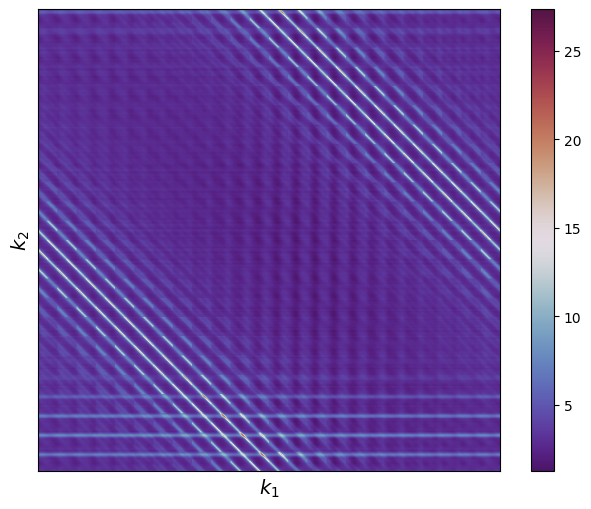

In [54]:
vertvis.plot_section(pred, 255, axis=3, figsize=(8,6))

## Evaluate

In [56]:
import numpy as np


In [84]:
# vertex reconstruction error
def reconstr_err(target: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(pred - vertex) / np.linalg.norm(target)

recerr = reconstr_err(vertex, pred)
recerr

0.06782501212528207

In [ ]:
# eigenvalue reconstruction errors


eigenvalues, eigenvectors = np.linalg.eig(pred[:,:,0])
len(eigenvalues)

In [93]:
et, _ = np.linalg.eig(vertex[:,:,0])
ep, _ = np.linalg.eig(pred[:,:,0])
sorted(abs(et) - abs(ep))

[-16.603054854308738,
 -8.73705845531866,
 -6.047905939013205,
 -5.096497126487918,
 -4.0603994020076755,
 -3.437334866358647,
 -3.4278187822464403,
 -3.396372196458799,
 -3.3677542824526583,
 -2.8505365006967516,
 -2.823668178241393,
 -2.8217525135441406,
 -2.6220673415432216,
 -2.4426288425095706,
 -2.3578484465369183,
 -2.3027480266967224,
 -2.2220143601956255,
 -2.200687548866185,
 -2.1428611410338156,
 -2.1214966658602097,
 -2.0693617041357992,
 -2.023019165582013,
 -1.9820313497249349,
 -1.9265533934335526,
 -1.7446407141738831,
 -1.6362894411267455,
 -1.5986066074324925,
 -1.5238116025273243,
 -1.4974563263754108,
 -1.451441388232099,
 -1.4483221780295676,
 -1.392246150392741,
 -1.3918965853533534,
 -1.3913931561715165,
 -1.3838159191858055,
 -1.3612311033962579,
 -1.3535136655474256,
 -1.3535136655474256,
 -1.34155205642592,
 -1.3310056687461826,
 -1.3182741598726508,
 -1.3171121870598337,
 -1.304480888013221,
 -1.2270809972396535,
 -1.219796161835884,
 -1.1941885105421308,
 -1

In [ ]:
# -> different for different sections
v1, _ = np.linalg.eig(pred[:,:,2])
v2, _ = np.linalg.eig(pred[:,:,167])
sorted(abs(v1) - abs(v2))

[-5.159774691615382,
 -5.159774691615382,
 -2.670358603649456,
 -2.6452022895458676,
 -2.5365652374371646,
 -2.5365652374371646,
 -2.1973631753281104,
 -1.7622380593573803,
 -1.7145238676950103,
 -1.7145238676950103,
 -1.311740927100895,
 -1.311740927100895,
 -1.2613336869798286,
 -1.2431897554938165,
 -1.2431897554938165,
 -1.2282179235558845,
 -1.224065307041875,
 -1.1832460134965346,
 -1.1832460134965346,
 -1.1791063429646211,
 -1.1791063429646211,
 -1.1762217297304596,
 -1.1762217297304596,
 -1.1660999242415686,
 -1.1200112784989842,
 -1.06492727661748,
 -1.0227705531644466,
 -0.9889097686528343,
 -0.9781178504381902,
 -0.8937074027219114,
 -0.8710658920033509,
 -0.8172803314982096,
 -0.723009973726648,
 -0.6963801310527509,
 -0.6883332648033775,
 -0.6883332648033775,
 -0.6579163662863117,
 -0.5928350208042978,
 -0.5738081907704013,
 -0.5738081907704013,
 -0.5694149003925997,
 -0.5128420527715569,
 -0.49820122265309585,
 -0.48083723367562836,
 -0.4739914493171584,
 -0.4667365511272

In [73]:
# RMSE
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

rmse_ = rmse(vertex, pred)
rmse_

0.2557820921515644

In [71]:
# relative errors
def rel_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.average(np.divide(np.abs(target - pred), np.abs(target)))

relerr = rel_error(vertex, pred)
relerr

0.045636286180477006

In [ ]:
# dimension compression rate
import math
from src.trainer import BaseTrainer

def compression_rate(trainer: BaseTrainer) -> float:
    in_dim = trainer.get_input_size()
    if not isinstance(in_dim, int):
        hidden = [math.prod(d) for d in trainer.config.hidden_dims]
        return min(hidden) / math.prod(in_dim)
    else:
        return min(trainer.config.hidden_dims) / in_dim

compr = compression_rate(trainer)
compr

0.07407407407407407